In [1]:
%matplotlib inline

In [2]:
# imports
import numpy as np
import scipy.signal as ss
from scipy.io import loadmat
import h5py
import matplotlib.pyplot as plt
import os

# convert .mat files to .h5 for easier i/o

In [3]:
datas_mat = [os.path.join('..', 'data', 'm4000series_LFP_ripple.mat')]
fname_h5 = os.path.join('..', 'data', 'm4000series_LFP_ripple.h5')

In [4]:
f = h5py.File(fname_h5, 'w')
for fname_mat in datas_mat:
    d = loadmat(fname_mat)
    for session_name, datas in d.items():
        if session_name not in ['__header__', '__version__', '__globals__']:
            grp = f.create_group(session_name)
            for i, (key, dtype) in enumerate(zip(['lfp', 'run_speed', 'rippleLocs'], 
                                                 [np.float, np.int32, np.int32])):
                grp[key] = datas[0, 0][i].flatten().astype(dtype)
f.close()

# apply complex wavelet transforms to data

In [5]:
# Wavelet parameters
Fs = 2500 # Hz, sampling frequency
dt = 1. / Fs
waveletfreqs = np.arange(50., 251, 10) # Hz

#set up continuous wavelets
w=6.
s=1.

#wavelets
waveletfun = ss.morlet
wavelets = []
for i, freq in enumerate(waveletfreqs):
    kwargs = {
        'M' : 2. * s * Fs * w / freq,
        'w' : w,
        's' : s,
        'complete' : True,
    }
    wl = waveletfun(**kwargs)
    wavelets.append(wl)

In [6]:
# apply wavelets and store wavelet spectrograms.
f = h5py.File(fname_h5, 'r+')
for key in f.keys():

    X0 = f[key]['lfp']

    # Container for preprocessed training/validation data
    X_cwt = np.empty((X0.shape + (waveletfreqs.size,)), dtype=complex)

    #apply wavelets
    for i, wavelet in enumerate(wavelets):
        X_cwt[:, i] = ss.convolve(X0, wavelet, 'same')
    
    # save envelope
    f[key]['cwt'] = np.abs(X_cwt).astype(float)**2
    f[key]['cwt_freqs'] = waveletfreqs
    
    # free memory
    del X_cwt
f.close()

# create training/validation datasets

In [7]:
# parameters for labels, and sample sizes
y_label_width = 250 # 100 ms @ Fs=2.5 kHz
sample_size = Fs    # 1000 ms @ Fs=2.5 kHz, number of time stamps per sample

# create arrays of training and validation samples combining data from all sessions
f = h5py.File(fname_h5, 'r')
X = []  # container for data
Y = []  # container for labels
labels = [] # data labels (session, rippleLoc, offset)
for session in f.keys():
    locs = f[session]['rippleLocs'][:]
    y = np.zeros_like(f[session]['lfp'])
    y[locs] = 1
    y = np.convolve(y, ss.boxcar(y_label_width), 'same')
    
    for loc in locs:
        # offset with some random jitter
        offset = -sample_size // 2        
        offset += np.random.randint(sample_size - y_label_width) - (sample_size - y_label_width) // 2
        
        # 
        inds = np.arange(sample_size) + loc + offset
        if inds.min() < 0:
            inds -= inds.min()
        elif inds.max() >= f[session]['lfp'].size:
            inds -= (inds.max() - f[session]['lfp'].size - 1) 
        X.append(f[session]['cwt'][inds, ])
        Y.append(np.expand_dims(y[inds], -1))
        labels.append((session, loc, offset))

# close file
f.close()

# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)
Y[Y>1] = 1 # fix cases where labels overlap
labels = np.array(labels, dtype=[('session', 'S16'), ('rippleLocs', np.int32), ('offset', np.int32)])

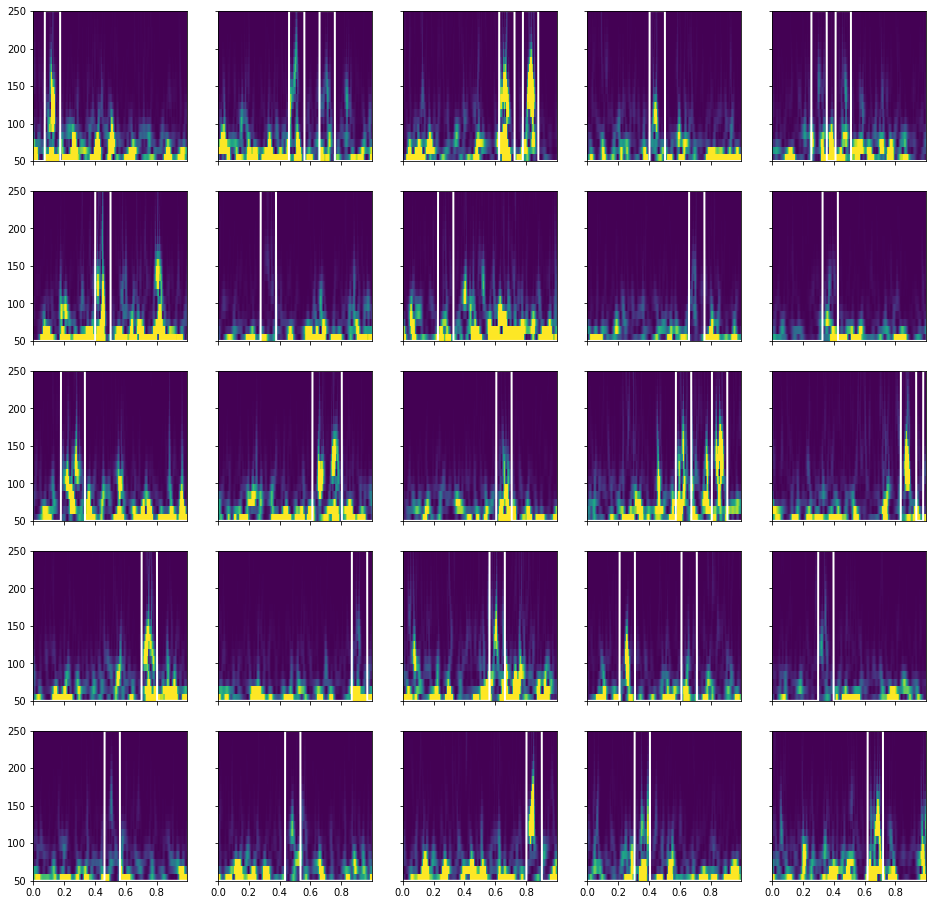

In [8]:
# sanity test of training data and labels:
fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)
inds = np.random.permutation(np.arange(labels.size))[:axes.size]
axes = axes.flatten()
t = np.arange(X.shape[1]) * dt
for i, ax in zip(inds, axes):
    ax.pcolormesh(t, waveletfreqs, X[i, ].T, vmin=0, vmax=X.std()*2) 
    ax.plot(t, Y[i, ]*(waveletfreqs.max()-waveletfreqs.min()) + waveletfreqs.min(), 'w', lw=2)

In [9]:
# save data
f = h5py.File(os.path.join('..', 'NewANN', 'data', 'processed', 'data.h5'), 'w')
f['X'] = X
f['Y'] = Y
f['labels'] = labels
f.close()